# Clustering

This script reads all embedding csvs in the folder_path and performs:
- UMAP dim reduction to 10 dims
- Clusters these with affinity propagation
- Uses a ch-sq test to check fidelity of clusters to whole classes
- Also plots a 2D UMAP 

make:
- load reefclr csvs into an object + imnet into another
- make side by side umap plots of each
- make pca as more precise?
- do chi-sq, plot table

notes 
- for aus and fp this should work
- for individual sounds it still should, it will 

Specify which embeddings to use

In [11]:
# Specify a list of categories you want to include
enabled_categories = ['ReefCLR', 'ImageNet', 'VGGish']  # Add or remove categories here

# Specify path to the embedding cvs's
csv_directory = '/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/evaluation/embeddings/raw_embeddings'

In [12]:
import os
import pandas as pd
import umap
from sklearn.cluster import AffinityPropagation
from scipy import stats
from datetime import datetime

Make a dictionary of all embeddings dataframes

In [26]:
# Initialize an empty dictionary
datasets = {}

# List all CSV files in the directory
all_csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

# alphabetise
all_csv_files.sort()

# Loop through each file and load it into the appropriate dictionary
for csv_file in all_csv_files:

    # Create the full path to the CSV file
    full_path = os.path.join(csv_directory, csv_file)

    # Determine the type and location name from the file name
    file_type, location = csv_file.split('-', 1)
    location = location.rsplit('-', 1)[0]  # Remove the "_embeddings.csv" part

    # Skip categories not in the enabled list
    if file_type not in enabled_categories:
        continue

    # Read the CSV file into a DataFrame
    df = pd.read_csv(full_path)
    
    # Add the DataFrame to the appropriate dictionary
    if file_type not in datasets:
        datasets[file_type] = {}
    datasets[file_type][location] = df

# Check dict was created correctly
for category, locations in datasets.items():
    print(f"Category: {category}")
    print(f"Locations: {list(locations.keys())}\n")

Category: ImageNet
Locations: ['australia', 'bermuda', 'florida', 'french_polynesia', 'indonesia', 'kenya']

Category: ReefCLR
Locations: ['australia', 'bermuda', 'florida', 'french_polynesia', 'indonesia', 'kenya']

Category: VGGish
Locations: ['australia', 'bermuda', 'florida', 'french_polynesia', 'indonesia', 'kenya']



In [17]:
# Initialize a results DataFrame to store the chi2 statistics and p-values
results = pd.DataFrame(columns=['Category', 'Location', 'Num_Clusters', 'Chi2_Stat', 'P_Value'])

# Loop through each category and its datasets
for category, locations in datasets.items():
    for location, df in locations.items():
        # Extract the features from the DataFrame
        features = df.loc[:, 'Feature_1':]  # Adjust this based on your DataFrame structure
        labels = df['Label']

        # UMAP dimensionality reduction. Number of dimensions is set by n_components.
        umap_embedding = umap.UMAP(
            n_neighbors=50,
            n_components=10,
            min_dist=0,
            random_state=0,
        ).fit_transform(features)

        # Affinity Propagation clustering
        af = AffinityPropagation(random_state=0, damping=0.9)
        clustering = af.fit(umap_embedding)
        num_clusters = len(clustering.cluster_centers_indices_)

        # Create contingency table
        class_type = labels.to_numpy()
        cluster_labels = clustering.labels_
        contingency_table = pd.crosstab(cluster_labels, class_type)

        # Chi-square test
        chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

        # Save results in DataFrame
        new_row = pd.DataFrame({'Category': [category], 
                                'Location': [location], 
                                'Num_Clusters': [num_clusters], 
                                'Chi2_Stat': [chi2_stat], 
                                'P_Value': [p_value]})
        results = pd.concat([results, new_row], ignore_index=True)

# order the results hdfere, so we get each location next to each other


# Generate a timestamp
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# order results so by location
results = results.sort_values(by=['Location', 'Category'])
# Save the DataFrame to a CSV file with a timestamp in the filename
results.to_csv(f"Results/chisq_results-{current_time}.csv", index=False)

results

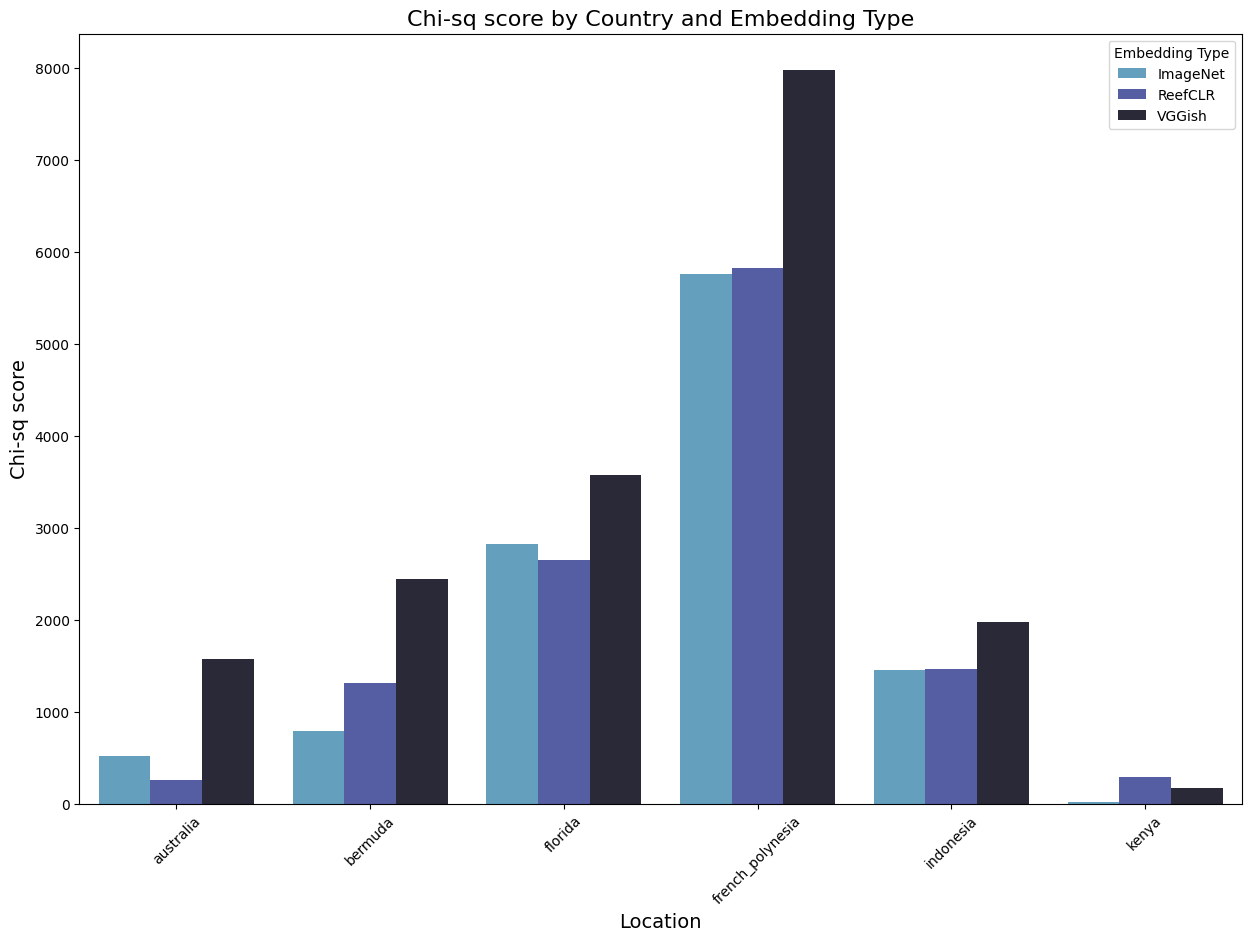

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice color palette for the plot
sns.set_palette("icefire")

# Create the bar plot
plt.figure(figsize=(15, 10))
sns.barplot(data=results, x='Location', y='Chi2_Stat', hue='Category')

# Add labels and title
plt.xlabel('Location', fontsize=14)
plt.ylabel('Chi-sq score', fontsize=14)
plt.title('Chi-sq score by Country and Embedding Type', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Embedding Type')

# Show the plot
plt.show()


# Visualise UMAPS

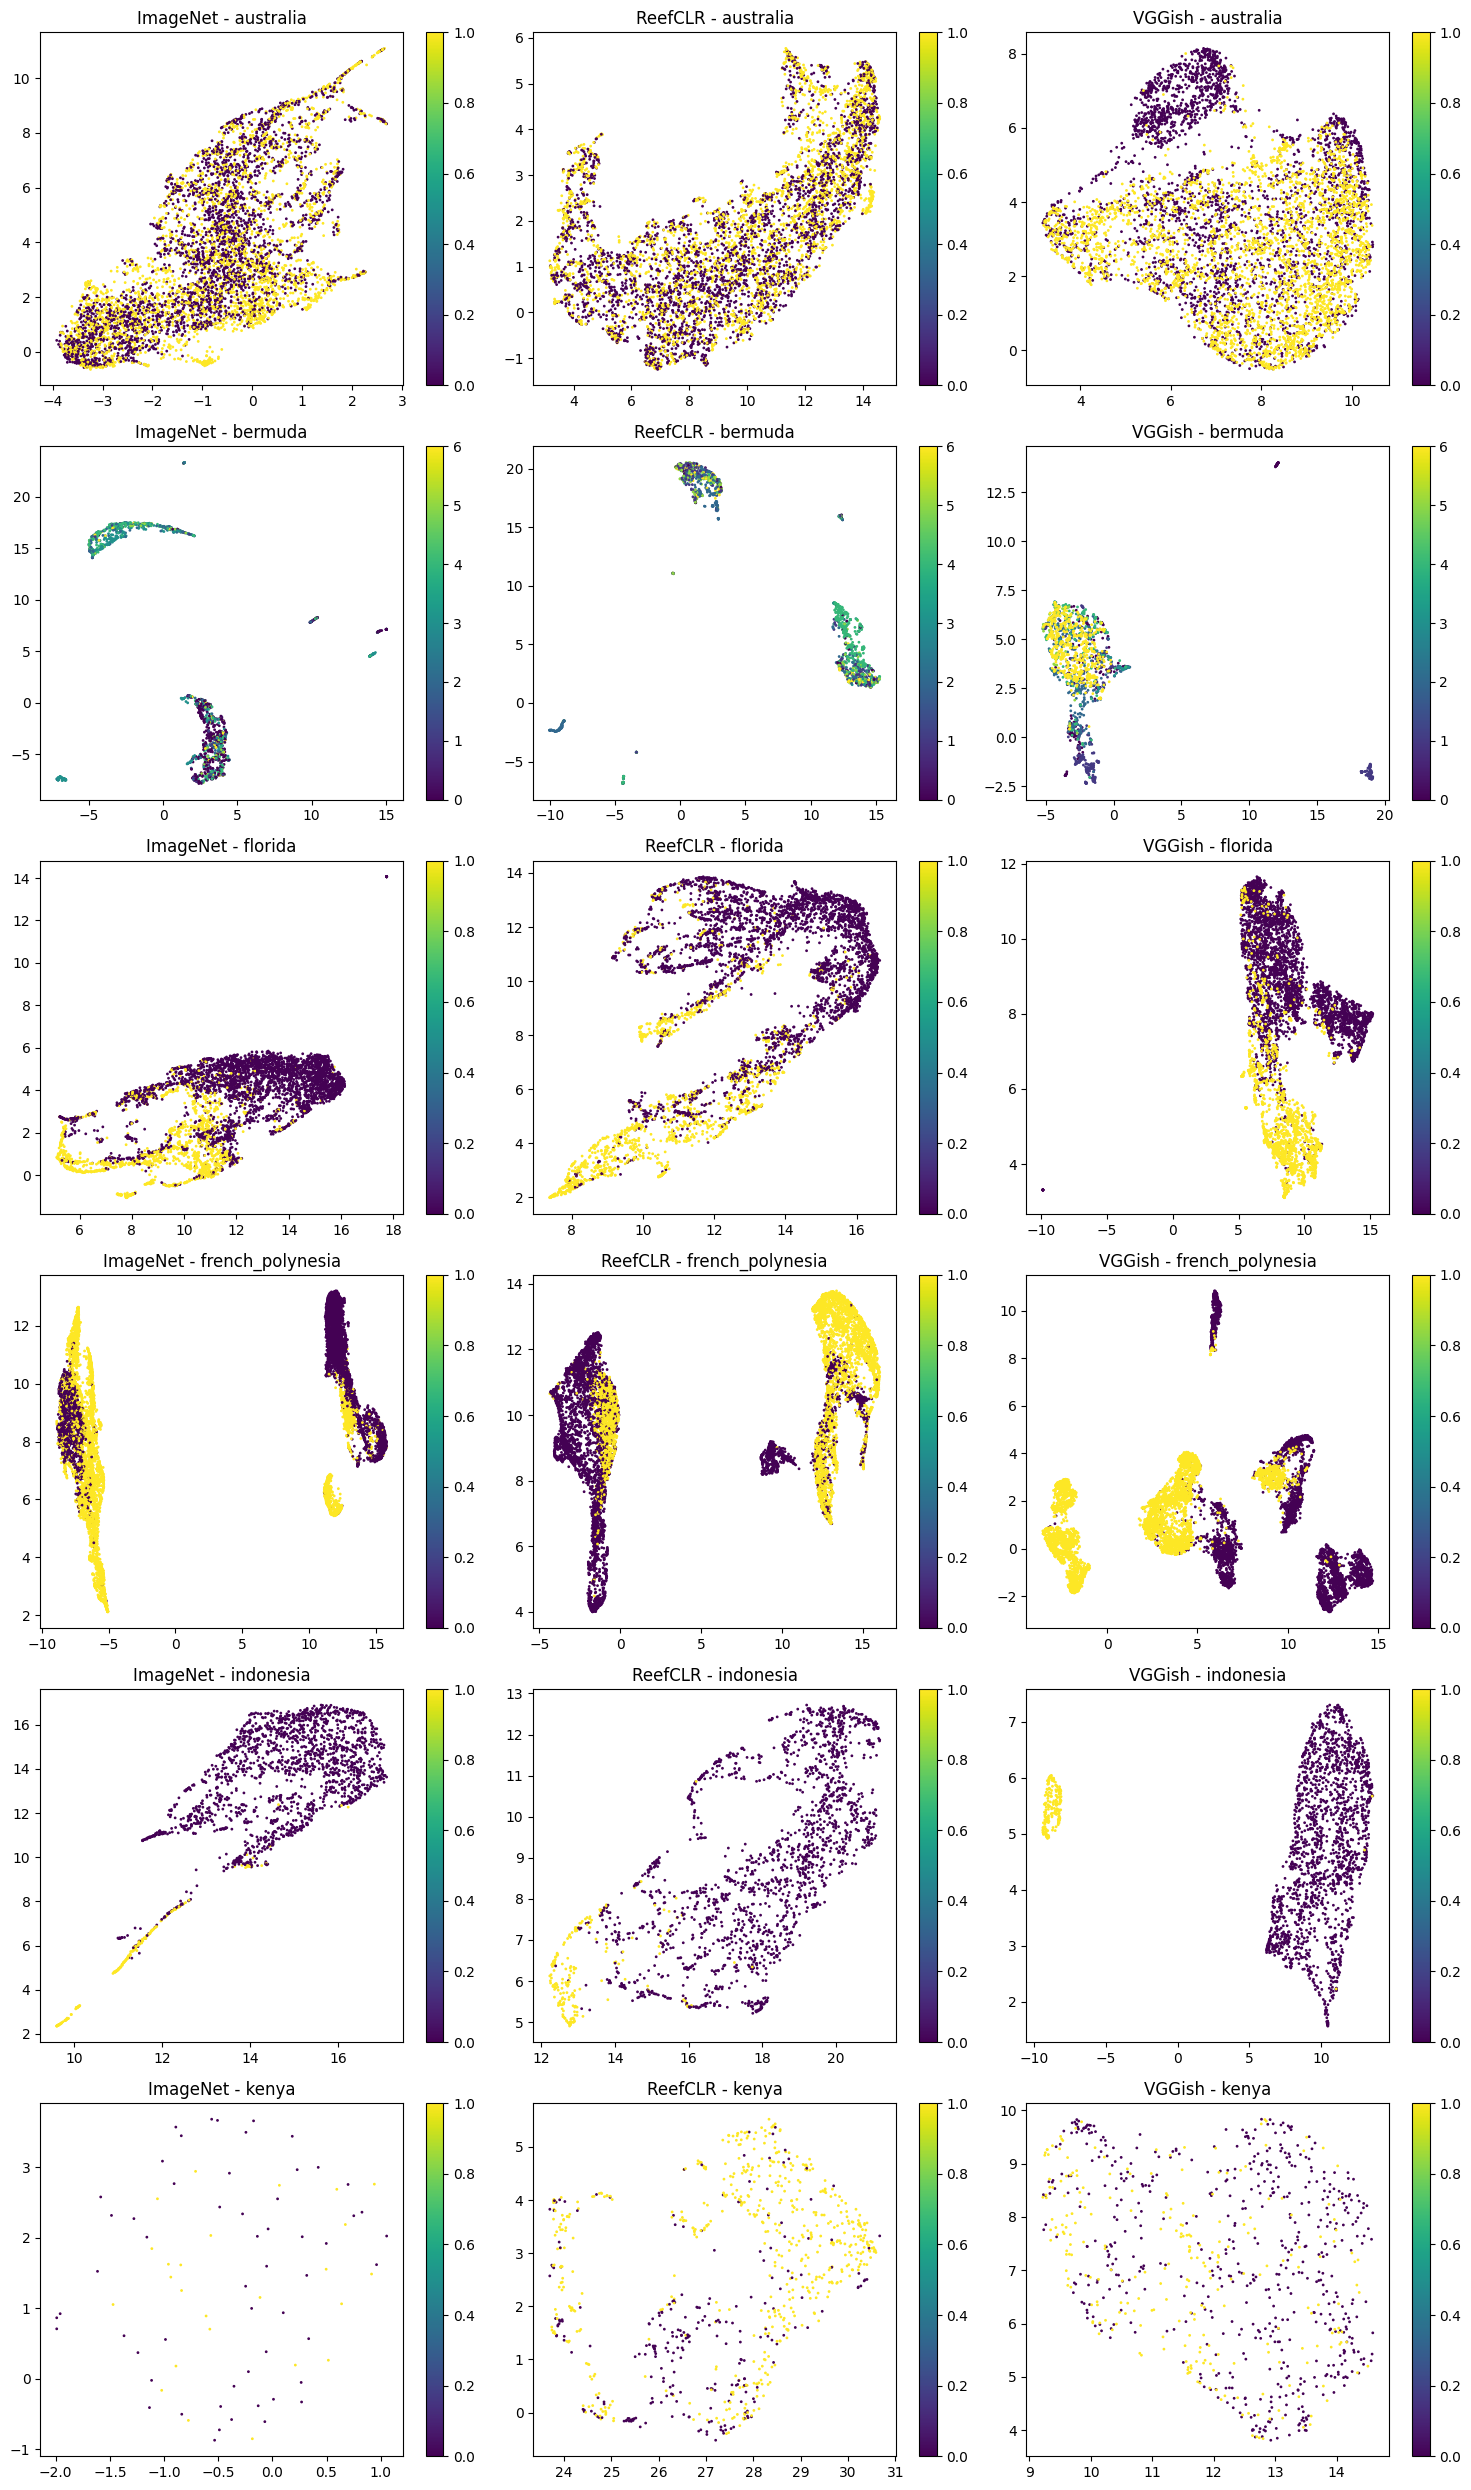

In [31]:
import matplotlib.pyplot as plt
import umap
import numpy as np
import pandas as pd

# Count the total number of unique locations and categories
total_locations = sum(len(locations) for locations in datasets.values())
total_categories = len(datasets)

# Initialize the plot grid
fig, axes = plt.subplots(len(datasets[list(datasets.keys())[0]]), total_categories, figsize=(15, 25))


# Ensure axes is always 2D
if total_locations == 1 and total_categories == 1:
    axes = np.array([[axes]])

# Loop through each category and each location to fill in the plots
for col_idx, (category, locations) in enumerate(datasets.items()):
    for row_idx, (location, df) in enumerate(locations.items()):
        ax = axes[row_idx, col_idx]

        # Perform UMAP dimensionality reduction
        features = df.loc[:, 'Feature_1':]
        embedding = umap.UMAP(
            n_neighbors=30,
            min_dist=0,
            n_components=2,
            random_state=42,
        ).fit_transform(features)

        # Create the scatter plot
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=df['Label'], s=1)
        plt.colorbar(scatter, ax=ax)

        ax.set_title(f'{category} - {location}')

plt.tight_layout()
plt.show()

# FIX - legend is currently incorect, shows a scale bar when it should show class labels

### Code for checking plot size

saves having to rerun the whole umpa stage

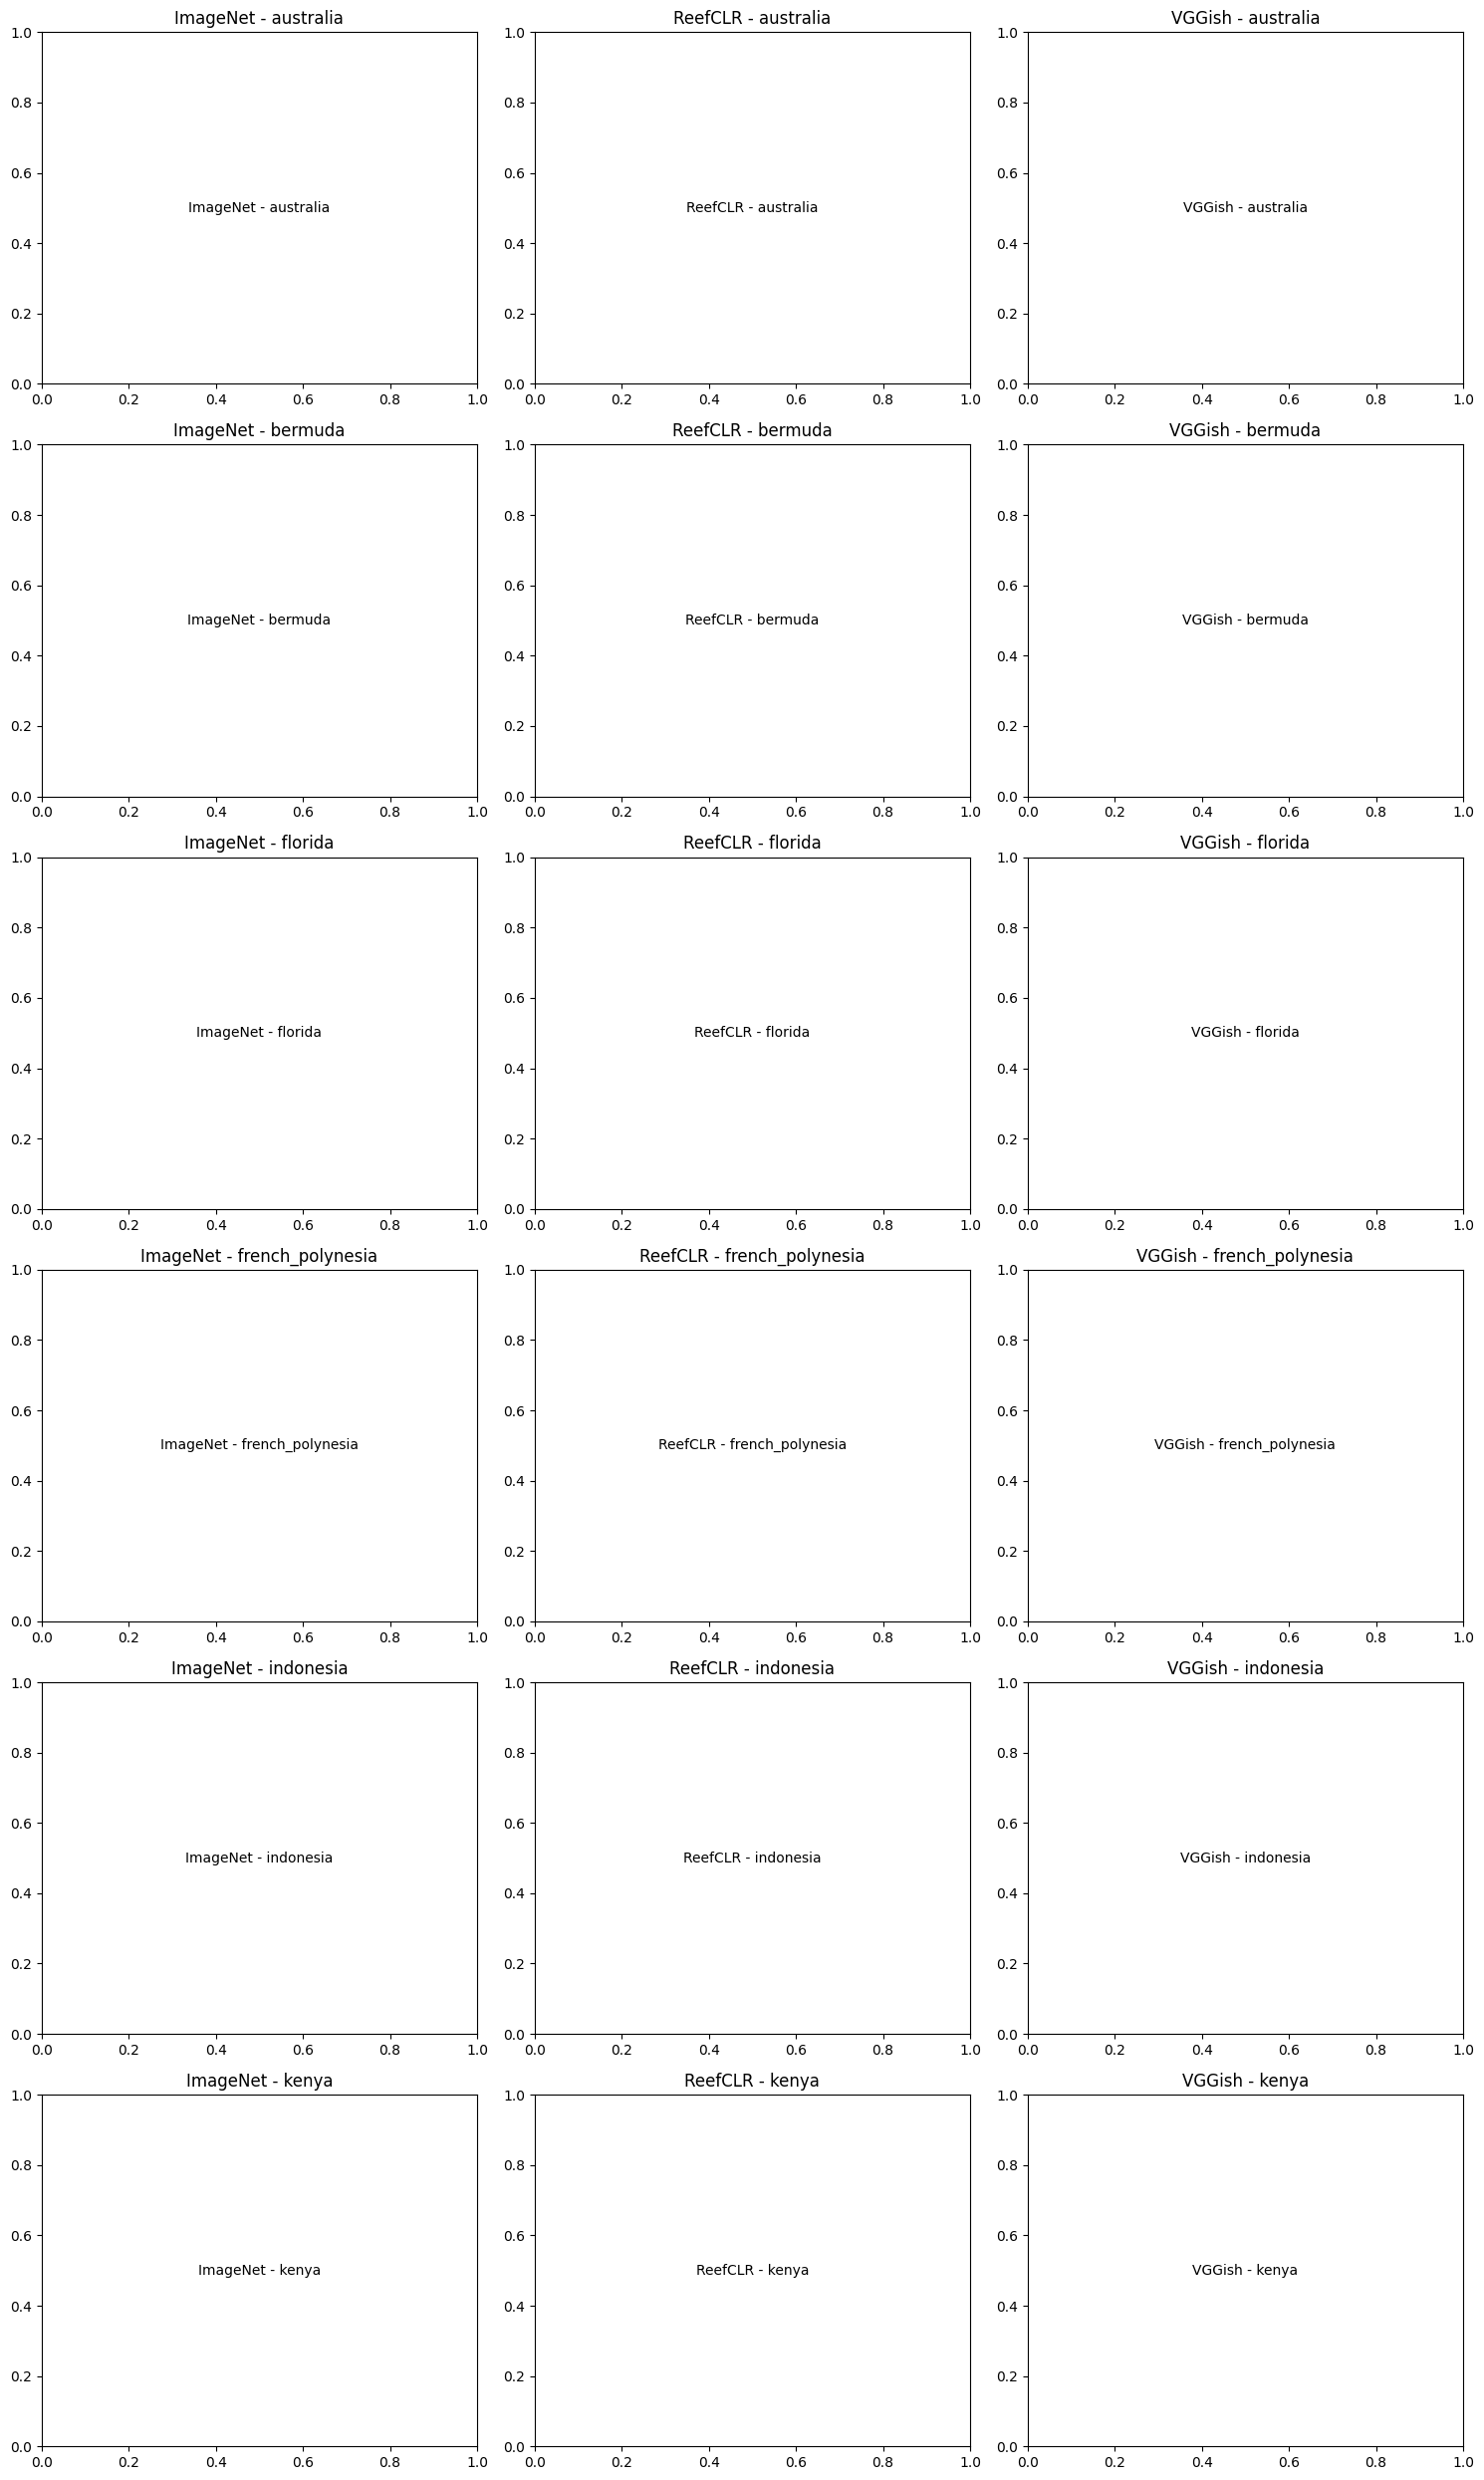

In [30]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Count the total number of unique locations and categories
# total_locations = sum(len(locations) for locations in datasets.values())
# total_categories = len(datasets)

# # Initialize the plot grid
# fig, axes = plt.subplots(len(datasets[list(datasets.keys())[0]]), total_categories, figsize=(15, 25))

# # Ensure axes is always 2D
# if total_locations == 1 and total_categories == 1:
#     axes = np.array([[axes]])

# # Loop through each category and each location to fill in the plots
# for col_idx, (category, locations) in enumerate(datasets.items()):
#     for row_idx, (location, df) in enumerate(locations.items()):
#         ax = axes[row_idx, col_idx]

#         # Comment out UMAP and scatter plot code for quick testing
#         '''
#         # Perform UMAP dimensionality reduction
#         features = df.loc[:, 'Feature_1':]
#         embedding = umap.UMAP(
#             n_neighbors=30,
#             min_dist=0,
#             n_components=2,
#             random_state=42,
#         ).fit_transform(features)

#         # Create the scatter plot
#         scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=df['Label'], s=1)
#         plt.colorbar(scatter, ax=ax)
#         '''
        
#         # Just add some text for identification
#         ax.text(0.5, 0.5, f'{category} - {location}', ha='center', va='center')
#         ax.set_title(f'{category} - {location}')

# plt.tight_layout()
# plt.show()
